In [28]:
import pandas as ad
import os 
import numpy as np
import SimpleITK as sitk
import matplotlib.pyplot as plt


In [29]:
def hu_transforme(img):
    window_level = -600
    window_width = 1500

    # Apply the windowing filter
    window_filter = sitk.IntensityWindowingImageFilter()
    window_filter.SetWindowMinimum(window_level - window_width/2.0)
    window_filter.SetWindowMaximum(window_level + window_width/2.0)
    window_filter.SetOutputMinimum(0)
    window_filter.SetOutputMaximum(255)
    image_windowed = window_filter.Execute(img)
    return image_windowed

In [53]:
def get_2ddataset(paths):
    
    df = ad.read_csv("D:/fin_de_etude/data/annotations.csv")
   
    j = 1
    for path in paths:
        for  file in os.listdir(path):
            if file.endswith(".mhd"):
                if file[:-4] in df["seriesuid"].tolist():
                    image = sitk.ReadImage(os.path.join(path, file))
                    image = hu_transforme(image)
                    df_2 = df[df["seriesuid"] == file[:-4]]
                    i = 1
                    
                    for index in df_2.index:
                        
                        x, y, z, d = df_2["coordX"][index], df_2["coordY"][index], df_2["coordZ"][index], df_2["diameter_mm"][index]
                 
                        point = (x, y, z) #  coordinates qui existe dans le fichier annotation
                        point_idx = image.TransformPhysicalPointToContinuousIndex(point) # transformer les coordinnaies de les données physique real a mond reél à des donnees presentable dans l'image
                        pixel_size = image.GetSpacing()[0]
                        
                        image_diameter = d /pixel_size
                                                   
                        

                        if index == df_2.index[0]  or np.abs(int( point_idx[2]) -int(slice))>1:

                            array_3d = sitk.GetArrayFromImage(image)
                            
                            arr_2d = array_3d[int(point_idx[2])]
                            np.save(os.path.join("D:/fin_de_etude/data/data2D/nodule/", f"{j}.{i}.npy"), arr_2d)
                            name = str(f"{j}.{i}")
                            i+=1
                    
                        slice = point_idx[2]
                        df["seriesuid"][index] = name
                        df["coordX"][index] = point_idx[0]
                        df["coordY"][index] = point_idx[1]
                        df["coordZ"][index] = int(point_idx[2])
                        df["diameter_mm"][index] = image_diameter
                else:
                    image = sitk.ReadImage(os.path.join(path, file))
                    image = hu_transforme(image)
                    array_3d = sitk.GetArrayFromImage(image)
                    
                    arr_2d = array_3d[array_3d.shape[0] // 2]
                    np.save(os.path.join("D:/fin_de_etude/data/data2D/nonnodule/",f"{j}.npy"), arr_2d)
                        
                j+=1
   
    df.to_csv("annotation_2.csv",index=False)



In [54]:
paths = ["D:/fin_de_etude/data/subset0","D:/fin_de_etude/data/subset1","D:/fin_de_etude/data/subset2",
         "D:/fin_de_etude/data/subset3","D:/fin_de_etude/data/subset4","D:/fin_de_etude/data/subset5",
         "D:/fin_de_etude/data/subset6","D:/fin_de_etude/data/subset7","D:/fin_de_etude/data/subset8",
         "D:/fin_de_etude/data/subset9"]
get_2ddataset(paths)

C:\Users\gamer\AppData\Local\Temp\ipykernel_19120\244430456.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["seriesuid"][index] = name
C:\Users\gamer\AppData\Local\Temp\ipykernel_19120\244430456.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["coordX"][index] = point_idx[0]
C:\Users\gamer\AppData\Local\Temp\ipykernel_19120\244430456.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["coordY"][index] = point_idx[1]


In [61]:
df = ad.read_csv("annotation_2.csv")
images = os.listdir("D:/fin_de_etude/data/data2D/nodule/")
print(len(images))
print(len(df["seriesuid"].unique()))
images = images[50:100]

1155
1155


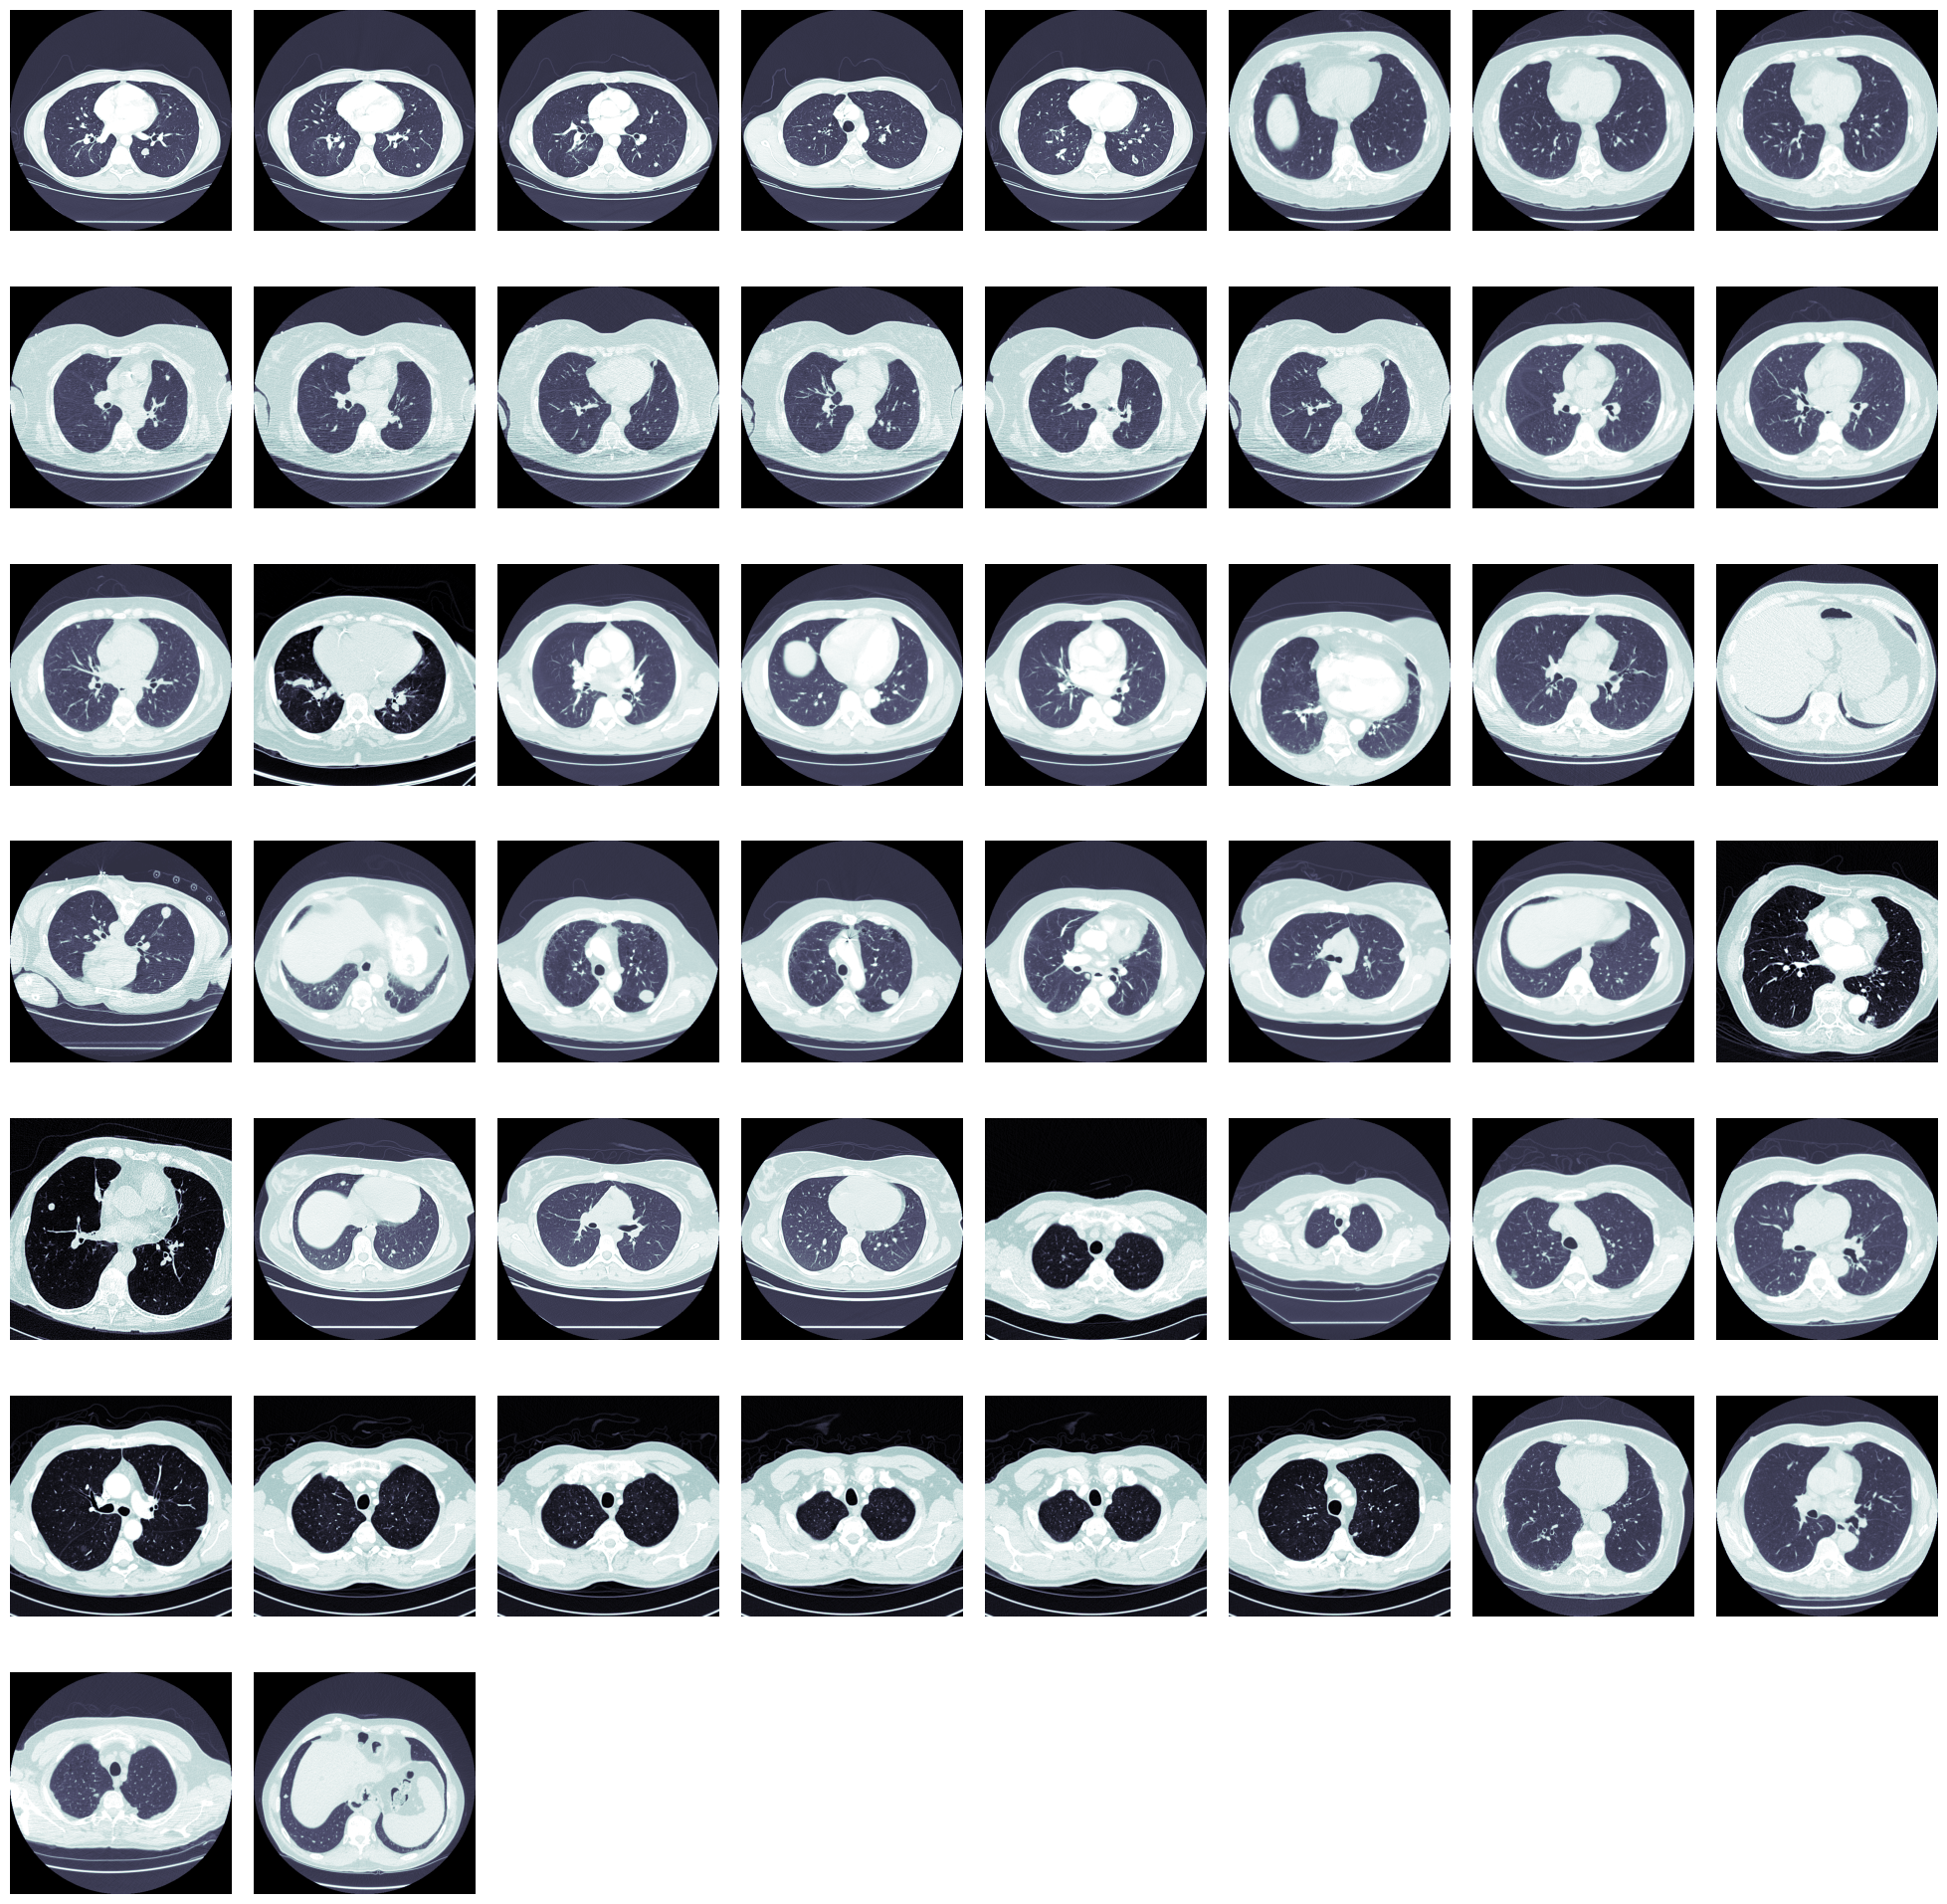

In [62]:
n_samples=len(images)
num_cols = int(np.ceil(np.sqrt(n_samples)))
num_rows = int(np.ceil(n_samples / num_cols))
fig = plt.figure(figsize=(25, 25))
i = 0
for file in images:
    img = np.load(os.path.join("D:/fin_de_etude/data/data2D/nodule/",file),allow_pickle=False)

    axs =   fig.add_subplot(
                                    num_rows, num_cols,  1+i)
    axs.axis('off')
    axs.imshow(img,cmap=plt.cm.bone)
        
            
    i+=1
    plt.subplots_adjust(wspace=0.1, hspace=0.1)
   
    # Show the plot
plt.show()


In [65]:
image_gray = np.load("D:/fin_de_etude/data/data2D/nodule/145.3.npy")

2
90.0 10.178109251414176
91.0 39.33872640995536


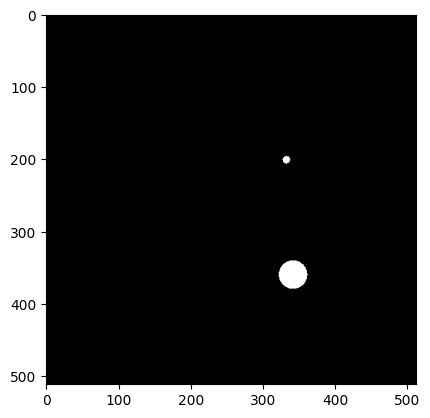

In [66]:
df = ad.read_csv("annotation_2.csv")
df = df[df["seriesuid"]== 145.3]
print(len(df))
mask = np.zeros(image_gray.shape)
for i in df.index:
    x, y,z, d =float( df["coordX"][i]), float(df["coordY"][i]),float(df["coordZ"][i]), float(df["diameter_mm"][i])
    xx, yy = np.meshgrid(np.arange(image_gray.shape[0]), np.arange(image_gray.shape[1]))
    print(z,d)
    dist = np.sqrt((xx - x) ** 2 + (yy - y) ** 2 )
    mask[dist <= d / 2] = 1
plt.imshow(mask,cmap="gray")

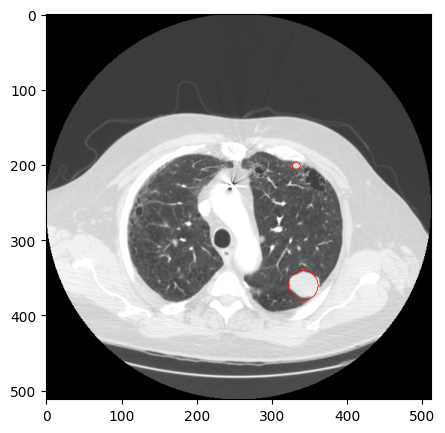

In [67]:
fig,ax1  = plt.subplots(ncols=1, figsize=(5, 5))
ax1.imshow(image_gray,cmap="gray" )

ax1.contour(mask, levels=[0.4], colors='r', linewidths=0.5)

plt.show()